### Pipeline optimization 
This code reads in a table of biogas sources -- including coordinates, estimated methane production costs (`$/MMBtu`), and pipeline delivery costs (`$/mi-MMBtu @15y`) -- and a cost surface, with units of mulitpliers (in percent) applied to building a section of pipeline through that cell. 

The code iterates through each biogas source and develops a least cost distance surface away from that source such that each pixel's value represents the aggregate cost to produce 1 MMbtu of methane and deliver it to that location. The result is a stack of these cost distance surfaces, one for each biogas source. 

The minimum value from the set of all cost distance surfaces represents the minimum cost to deliver methane to that site. It can be thresholded (identify all cells below a set minimum cost) to identify all areas that are cost effective to connect at a set price point. This would also identify other biogas sources that alone are not cost effective, but when considered alongside other sites, become cost effective. 

Summer 2019, john.fay@duke.edu

In [1]:
#Import packages
import numpy as np
import pandas as pd
import geopandas as gpd
from osgeo import gdal 
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [39]:
#Read in the min value array
ds =  gdal.Open('../scratch/lowest_cost.tif')
#Get the raster projection
ds_prj = ds.GetProjection()
#Get raster attributes
llx, x_size, x_angle, lly, y_angle, y_size = ds.GetGeoTransform()
#Extract Band1 as the cost array; divide by 100 to scale as a percentage
arrMin = np.array(ds.GetRasterBand(1).ReadAsArray()) / 100
#Print info

In [3]:
#Read the biogas sources into a geodataframe
gdfBG = gpd.read_file('../data/DuplinSites_Prj.shp')

In [ ]:
#Import the cost distance stack
arrStack = np.load('../data/DuplinStack.npy')

In [ ]:
#Compute the overall minimum across all layers in the stack
arrMin = np.amin(arrStack,axis=0)

In [32]:
#Create a masked grid of min values
arrMin = np.ma.masked_array(arrMin,mask=arrMin<0) * 100

### Plotting
https://stackoverflow.com/questions/10917495/matplotlib-imshow-in-3d-plot

In [59]:
#Create mesh grid for plotting
y = np.arange(0,arrMin.shape[0])
x = np.arange(0,arrMin.shape[1])
X,Y  = np.meshgrid(x,y)
Z = arrMin * 100
#Set cap on Z values
Z[Z<0]=np.NaN

In [44]:
#Establish colors and color ramps to use across plots
norm = cm.colors.Normalize(vmax=abs(arrMin).max(), vmin=-abs(arrMin).max())
lnorm = cm.colors.Normalize(2,5)
cmap = cm.PRGn

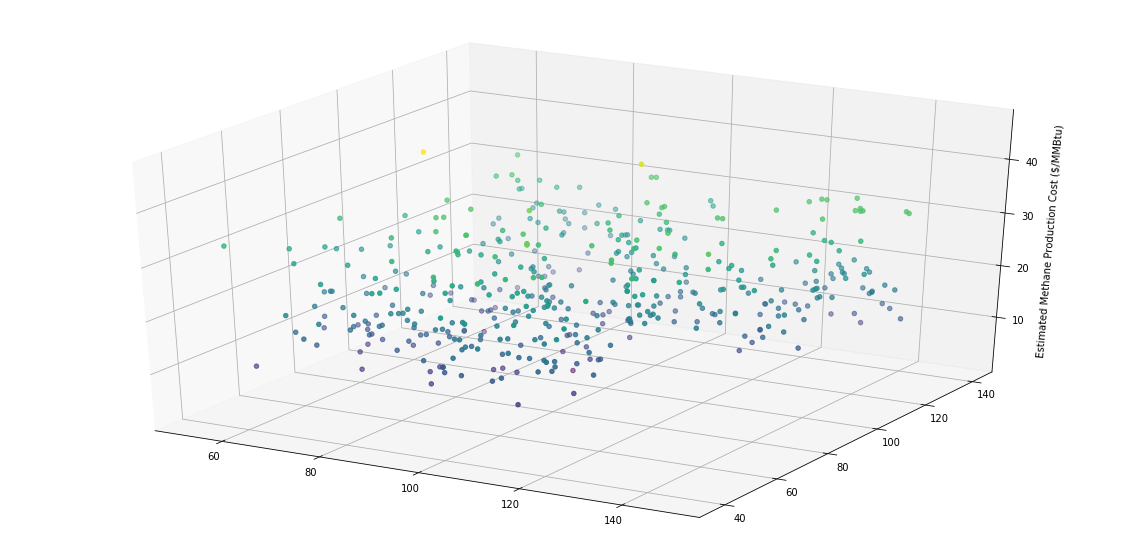

In [54]:
#Build 3d array of base cost values

#Set the axis values
xValues = gdfBG['xOffset'] #X offsets
yValues = gdfBG['yOffset'] #Y offsets
zValues = gdfBG['Estimated'] #Production costs 

#Construct the figure
fig = plt.figure(1,figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(xValues,yValues,zValues,c=zValues);
#ax.set_xlabel("Longitude")
#ax.set_ylabel("Latitude")
ax.set_zlabel("Estimated Methane Production Cost ($/MMBtu)");

C:\Users\jpfay\AppData\Local\ESRI\conda\envs\bg_optimi\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  after removing the cwd from sys.path.


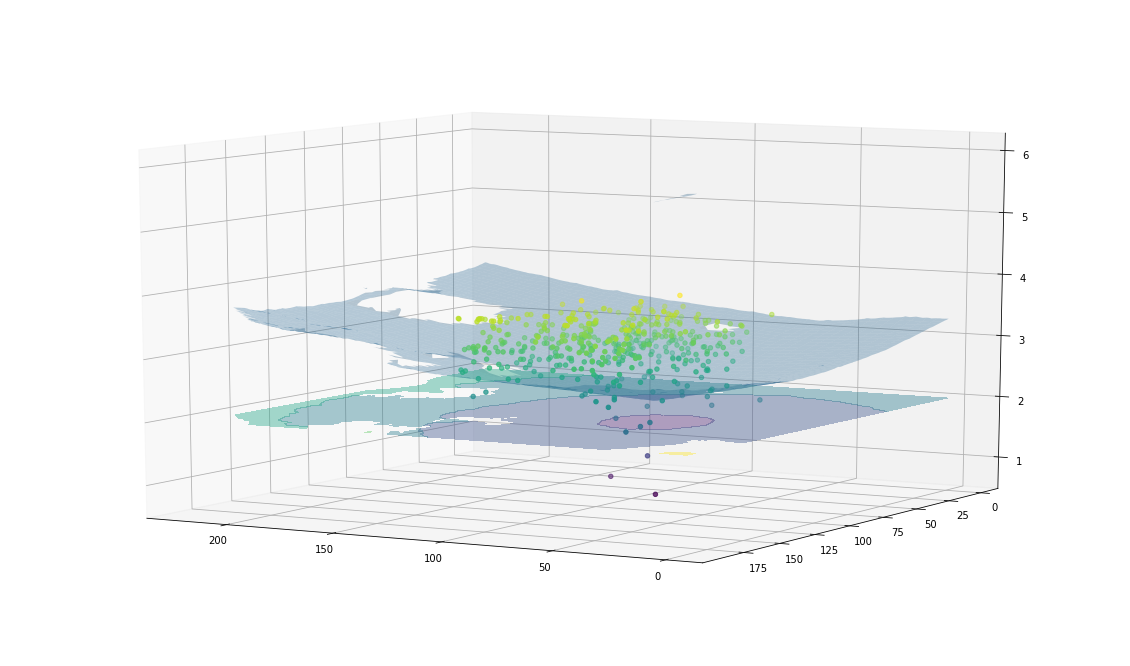

In [53]:
#plt.clf()
fig = plt.figure(1,figsize=(20,12))
ax = fig.gca(projection='3d')
ax.plot_surface(X,Y,Z, alpha=0.3)#,rstride=80, cstride=80)
#Add the image at the bottom
cset = ax.contourf(X,Y,Z,zdir='z',offset=2,cmap='viridis',alpha=0.4,norm=lnorm)
ax.scatter3D(xValues,yValues,zValues,c=zValues)
#Aesthetics
#ax.set_xlabel('X');ax.set_xlim(0,220)
#ax.set_ylabel('Y');ax.set_ylim(0,220)
#ax.set_zlabel('Z');ax.set_zlim(2, 5)  
ax.view_init(10,120);

C:\Users\jpfay\AppData\Local\ESRI\conda\envs\bg_optimi\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  # This is added back by InteractiveShellApp.init_path()


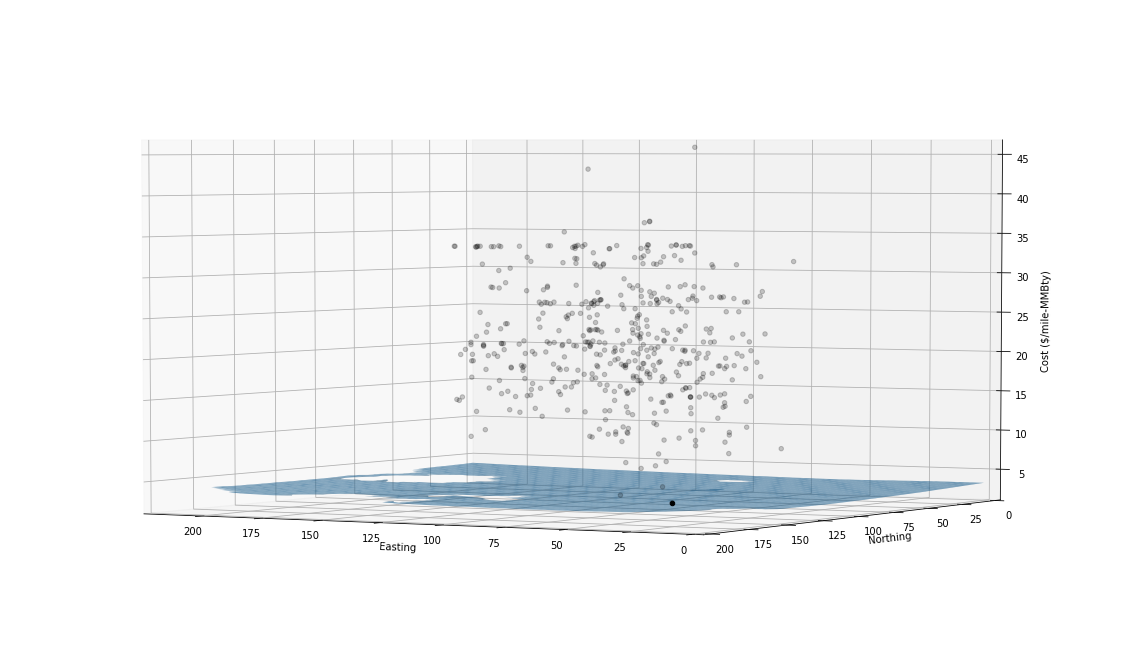

In [64]:
#Create a 3 point for the lowest cost site
X1,Y1,Z1=gdfBG.loc[0,['xOffset','yOffset','Estimated']]
X_all = gdfBG.xOffset
Y_all = gdfBG.yOffset
Z_all = gdfBG.Estimated

#3D plotting
fig = plt.figure(figsize=(20,12))            #Create the figure canvas
ax = fig.add_subplot(111, projection='3d')   #Add 3d plot...
#ax.contour3D(X,Y,arrMinCopy,100,alpha=0.2,cmap='ocean')
ax.plot_surface(X,Y,Z,linewidth=0,alpha=0.6)
#ax.plot_surface(X,Y,arrThreshold,linewidth=0,alpha=0.3)
#ax.scatter3D(X1m,Y1m,np.log(Z1),color='r')
ax.scatter3D(X1,Y1,Z1,color='Black')
#ax.scatter3D(gdfBG_prj.iloc[:,-2],gdfBG_prj.iloc[:,-1],gdfBG_prj.iloc[:,3], c=gdfBG_prj.iloc[:,3],cmap='Greens');
#ax.scatter3D(gdf.xOffset,dfBG.yOffset,dfBG['Estimated Methane Production Cost ($/MMBtu)'], cmap='ocean')
ax.scatter3D(X_all,Y_all,Z_all, color='k',alpha=0.2)
ax.set_xlabel('Easting');ax.set_xlim(0,220)
ax.set_ylabel('Northing');ax.set_ylim(0,200)
ax.set_zlabel('Cost ($/mile-MMBty)',rotation=90);ax.set_zlim(2, Z_all.max())  
ax.view_init(3,120);

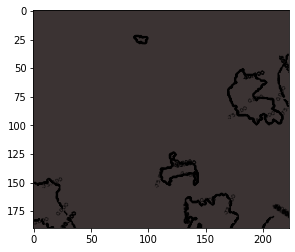

In [8]:
#Simple plot of the minimum surface with contours
contours = plt.contour(arrMin,colors='black',origin='lower')
lnorm = cm.colors.Normalize(2.,3.5)
plt.clabel(contours,inline=True,fontsize=6)
plt.imshow(arrMin,norm=lnorm,cmap='hot',alpha=0.8);

In [9]:
#Create a 3 point for the lowest cost site
X1,Y1,Z1 = gdfBG.iloc[0,[-2,-1,3]].values
#X1m,Y1m = np.meshgrid(X1,Y1)

In [10]:
#Create a mesh grid from the row and column
y = np.arange(0,arrMin.shape[0])
x = np.arange(0,arrMin.shape[1])
X,Y  = np.meshgrid(x,y)

#Create copies of the arrMin surface
arrMinCopy = arrMin.copy()
arrMinCopy[arrMin < 0]=0
arrMinCopy[arrMin > 5]=5
arrThreshold = np.full(arrMinCopy.shape,3)

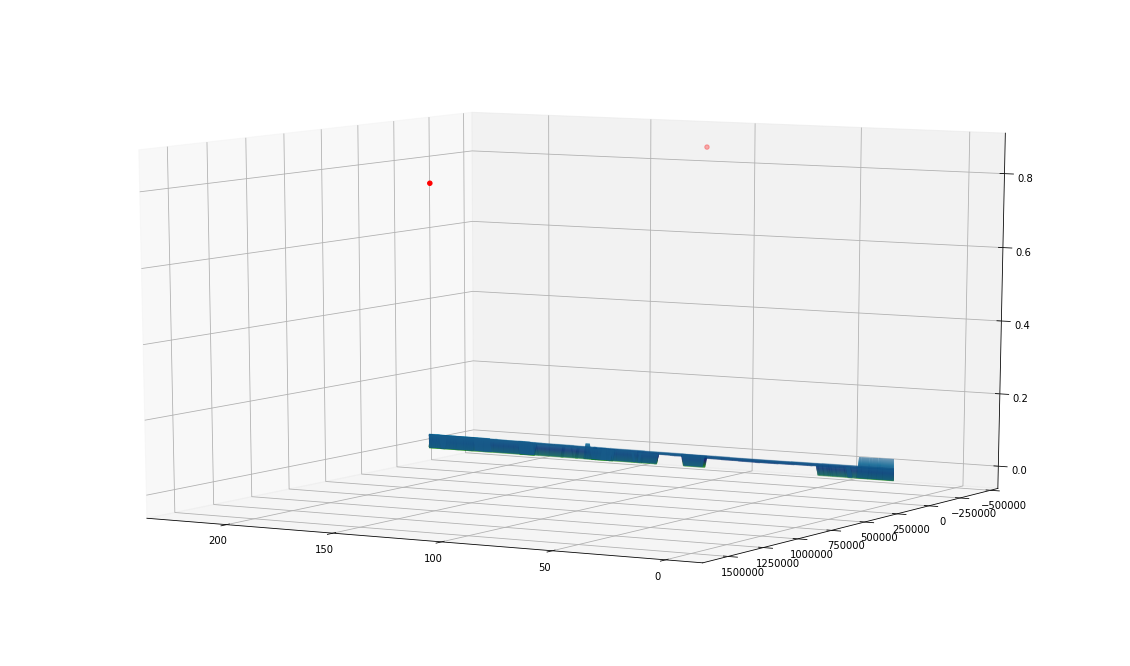

In [11]:
#3D plotting
fig = plt.figure(figsize=(20,12))            #Create the figure canvas
ax = fig.add_subplot(111, projection='3d')   #Add 3d plot...

ax.contour3D(X,Y,arrMinCopy,100,alpha=0.2,cmap='ocean')
ax.plot_surface(X,Y,arrMinCopy,linewidth=0,alpha=0.6)
#ax.plot_surface(X,Y,arrThreshold,linewidth=0,alpha=0.3)
ax.scatter3D(X1,Y1,np.log(Z1),color='r')
#ax.scatter3D(X1,Y1,Z1,color='y')
#ax.scatter3D(gdfBG_prj.iloc[:,-2],gdfBG_prj.iloc[:,-1],gdfBG_prj.iloc[:,3], c=gdfBG_prj.iloc[:,3],cmap='Greens');
#ax.scatter3D(gdf.xOffset,dfBG.yOffset,dfBG['Estimated Methane Production Cost ($/MMBtu)'], cmap='ocean')
#ax.scatter3D(gdfBG_prj.iloc[0,-2],gdfBG_prj.iloc[0,-1],gdfBG_prj.iloc[0,3], color='k');
ax.view_init(10,120);